## Import Packages and Data 

In [2]:
import tensorflow as tf                  # TensorFlow
import tensorflow.nn as nn               # nn contains useful neural network functions like softmax, relu, tanh
from tensorflow import keras             # high level API for TensorFlow
import tensorflow.keras.layers as layers # contains layers like RNN, CNN, LSTM
import numpy as np                       # standard numerical python
# used to partition datasets
from sklearn.model_selection import train_test_split  

#####

import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,LSTM,BatchNormalization,MaxPooling2D,Reshape,Bidirectional,GRU
from keras.utils import to_categorical
import matplotlib.pyplot as plt

In [3]:
def data_split(X,Y,person):
    num_persons = 9 
    X_person = []
    Y_person = [] 
    
    for i in range(num_persons): 
        index = np.where(person == i)[0]

        X_person.append(X[index, :, :]) 
        Y_person.append(Y[index]) 
        
    return X_person, Y_person 

In [4]:
def data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,0:500]
    #print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    #print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    #print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    #print('Shape of X after subsampling and concatenating:',total_X.shape)
    return total_X,total_y

In [5]:
def preprocessing(X, Y, X_test, Y_test):
    ## Splits a dataset into training and validation sets and pre-processes them
    
    ## Determine the size of the input 
    train_size = X.shape[0] 
    valid_size = int(np.ceil(train_size/6))
    
    ind_valid = np.random.choice(train_size, valid_size, replace=False)
    ind_train = np.array(list(set(range(train_size)).difference(set(ind_valid))))
    
    # Creating the training and validation sets using the generated indices
    (X_train, X_valid) = X[ind_train], X[ind_valid] 
    (y_train, y_valid) = Y[ind_train], Y[ind_valid]
      
    ## Preprocessing the dataset
    x_train,y_train = data_prep(X_train,y_train,2,2,True)
    x_valid,y_valid = data_prep(X_valid,y_valid,2,2,True)
    X_test_prep,y_test_prep = data_prep(X_test,Y_test,2,2,True)
    
    #print('Shape of training set:',x_train.shape)
    #print('Shape of validation set:',x_valid.shape)
    #print('Shape of training labels:',y_train.shape)
    #print('Shape of validation labels:',y_valid.shape)
    #print('Shape of testing set:',X_test_prep.shape)
    #print('Shape of testing labels:',y_test_prep.shape)
       
    # Converting the labels to categorical variables for multiclass classification
    y_train = to_categorical(y_train, 4)
    y_valid = to_categorical(y_valid, 4)
    y_test = to_categorical(y_test_prep, 4)
    #print('Shape of training labels after categorical conversion:',y_train.shape)
    #print('Shape of validation labels after categorical conversion:',y_valid.shape)
    #print('Shape of test labels after categorical conversion:',y_test.shape)
    
    # Adding width of the segment to be 1
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
    x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
    x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
    #print('Shape of training set after adding width info:',x_train.shape)
    #print('Shape of validation set after adding width info:',x_valid.shape)
    #print('Shape of test set after adding width info:',x_test.shape)

    # Reshaping the training and validation dataset
    x_train = np.swapaxes(x_train, 1,3)
    x_train = np.swapaxes(x_train, 1,2)
    x_valid = np.swapaxes(x_valid, 1,3)
    x_valid = np.swapaxes(x_valid, 1,2)
    x_test = np.swapaxes(x_test, 1,3)
    x_test = np.swapaxes(x_test, 1,2)
    #print('Shape of training set after dimension reshaping:',x_train.shape)
    #print('Shape of validation set after dimension reshaping:',x_valid.shape)
    #print('Shape of test set after dimension reshaping:',x_test.shape)
    
    return y_train, y_valid, y_test, x_train, x_valid, x_test

In [6]:
## Loading the dataset
X_test = np.load("X_test.npy")
Y_test = np.load("y_test.npy")
person_test = np.load("person_test.npy")
X_train_valid = np.load("X_train_valid.npy")
Y_train_valid = np.load("y_train_valid.npy")
person_train_valid = np.load("person_train_valid.npy")

## Adjust the dataset labels to be 0,1,2,3
Y_train_valid -= 769
Y_test -= 769 

## Split the dataset into those belonging to individual people 
Xp_train_valid, Yp_train_valid = data_split(X_train_valid, Y_train_valid, person_train_valid)
Xp_test, Yp_test = data_split(X_test, Y_test, person_test) 

## Preprocess Data 

In [7]:
## Preprocess a single person dataset 
person = 0  #Set which person you'd like to look at (from 0 to 8)
yp_train, yp_valid, yp_test, xp_train, xp_valid, xp_test = preprocessing(Xp_train_valid[person], Yp_train_valid[person], Xp_test[person], Yp_test[person])

In [8]:
## Preprocess the entire dataset 
y_train, y_valid, y_test, x_train, x_valid, x_test = preprocessing(X_train_valid, Y_train_valid, X_test, Y_test)

## Models 

### Basic CNN

In [10]:
# Building the CNN model using sequential class
basic_cnn_model = Sequential()

# Conv. block 1
basic_cnn_model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', input_shape=(250,1,22)))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Conv. block 2
basic_cnn_model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
basic_cnn_model.add(MaxPooling2D(pool_size=(1,1), padding='same'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Conv. block 3
basic_cnn_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Conv. block 4
basic_cnn_model.add(Conv2D(filters=200, kernel_size=(10,1), padding='same', activation='elu'))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Output layer with Softmax activation
basic_cnn_model.add(Flatten()) # Flattens the input
basic_cnn_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


# Printing the model summary
basic_cnn_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 250, 1, 25)        5525      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 84, 1, 25)        0         
 2D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 84, 1, 25)        100       
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 84, 1, 25)         0         
                                                                 
 conv2d_5 (Conv2D)           (None, 84, 1, 50)         12550     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 84, 1, 50)       

### Train Basic CNN on Subject 1

Epoch 1/50
13/13 [==============================] - 4s 137ms/step - loss: 2.2842 - accuracy: 0.3173 - val_loss: 5.5901 - val_accuracy: 0.2562 - lr: 0.0010
Epoch 2/50
13/13 [==============================] - 1s 108ms/step - loss: 1.8389 - accuracy: 0.4124 - val_loss: 2.7711 - val_accuracy: 0.3375 - lr: 0.0010
Epoch 3/50
13/13 [==============================] - 1s 112ms/step - loss: 1.7062 - accuracy: 0.4442 - val_loss: 2.2151 - val_accuracy: 0.3500 - lr: 0.0010
Epoch 4/50
13/13 [==============================] - 1s 113ms/step - loss: 1.5094 - accuracy: 0.4670 - val_loss: 1.9930 - val_accuracy: 0.3562 - lr: 0.0010
Epoch 5/50
13/13 [==============================] - 1s 115ms/step - loss: 1.4460 - accuracy: 0.5089 - val_loss: 1.8449 - val_accuracy: 0.3812 - lr: 0.0010
Epoch 6/50
13/13 [==============================] - 1s 108ms/step - loss: 1.2716 - accuracy: 0.5495 - val_loss: 1.6252 - val_accuracy: 0.4313 - lr: 0.0010
Epoch 7/50
13/13 [==============================] - 2s 123ms/step - lo

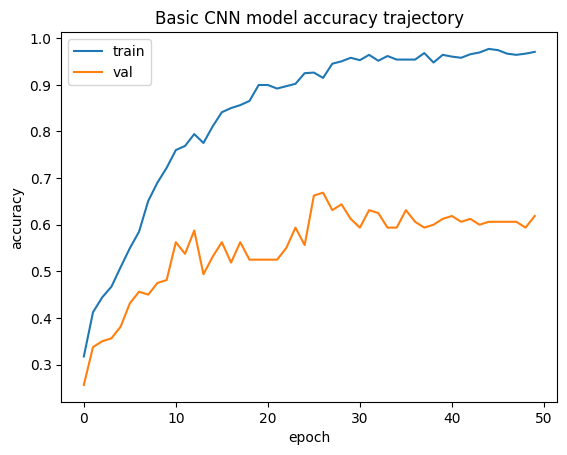

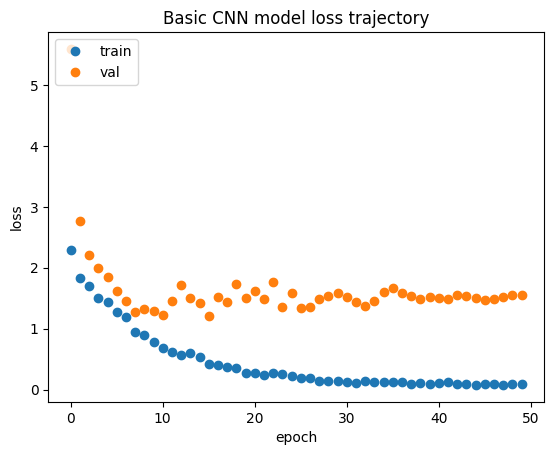

Test accuracy of the basic CNN model on Subject 1: 0.6650000214576721


In [11]:
# Model parameters
lr = 1e-3
epochs = 50
cnn_optimizer = keras.optimizers.Adam(learning_rate=lr)
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(patience = 10, factor = 0.5)  # reduces by a factor of 0.5 if validation loss doesn't improve for 10 epochs

person = 0  #Set which person you'd like to look at (from 0 to 8)
yp_train, yp_valid, yp_test, xp_train, xp_valid, xp_test = preprocessing(Xp_train_valid[person], Yp_train_valid[person], Xp_test[person], Yp_test[person])

# Compiling the model
basic_cnn_model.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
basic_cnn_model_results = basic_cnn_model.fit(xp_train,
             yp_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(xp_valid, yp_valid), 
             callbacks=[lr_callback], 
             verbose=True)

# Plotting accuracy trajectory
plt.plot(basic_cnn_model_results.history['accuracy'])
plt.plot(basic_cnn_model_results.history['val_accuracy'])
plt.title('Basic CNN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(basic_cnn_model_results.history['loss'],'o')
plt.plot(basic_cnn_model_results.history['val_loss'],'o')
plt.title('Basic CNN model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Testing the basic CNN model
cnn_score = basic_cnn_model.evaluate(xp_test, yp_test, verbose=0)
print('Test accuracy of the basic CNN model on Subject 1:',cnn_score[1])

### Train Basic CNN on all subjects

Epoch 1/50
111/111 [==============================] - 30s 256ms/step - loss: 1.6272 - accuracy: 0.4718 - val_loss: 1.2281 - val_accuracy: 0.5035 - lr: 0.0010
Epoch 2/50
111/111 [==============================] - 25s 229ms/step - loss: 1.1837 - accuracy: 0.5349 - val_loss: 1.2280 - val_accuracy: 0.5078 - lr: 0.0010
Epoch 3/50
111/111 [==============================] - 23s 211ms/step - loss: 1.0584 - accuracy: 0.5840 - val_loss: 1.0703 - val_accuracy: 0.5475 - lr: 0.0010
Epoch 4/50
111/111 [==============================] - 20s 184ms/step - loss: 0.9627 - accuracy: 0.6210 - val_loss: 1.0514 - val_accuracy: 0.5751 - lr: 0.0010
Epoch 5/50
111/111 [==============================] - 19s 168ms/step - loss: 0.9071 - accuracy: 0.6410 - val_loss: 1.1262 - val_accuracy: 0.5489 - lr: 0.0010
Epoch 6/50
111/111 [==============================] - 18s 160ms/step - loss: 0.8339 - accuracy: 0.6731 - val_loss: 1.0027 - val_accuracy: 0.5992 - lr: 0.0010
Epoch 7/50
111/111 [==============================] 

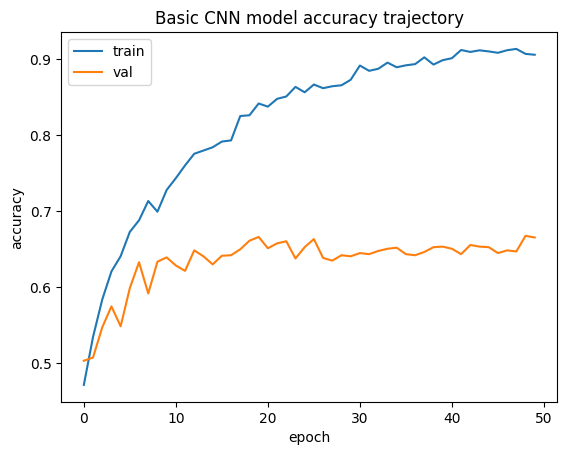

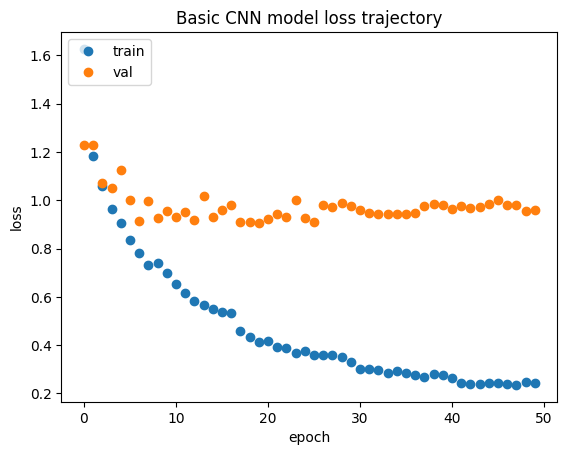

Test accuracy of the basic CNN model on all subjects: 0.694695234298706


In [12]:
# Model parameters
lr = 1e-3
epochs = 50
cnn_optimizer = keras.optimizers.Adam(learning_rate=lr)
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(patience = 10, factor = 0.5)  # reduces by a factor of 0.5 if validation loss doesn't improve for 10 epochs

## Preprocess the entire dataset 
y_train, y_valid, y_test, x_train, x_valid, x_test = preprocessing(X_train_valid, Y_train_valid, X_test, Y_test)

# Compiling the model
basic_cnn_model.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
basic_cnn_model_results = basic_cnn_model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid, y_valid), 
             callbacks=[lr_callback], 
             verbose=True)

# Plotting accuracy trajectory
plt.plot(basic_cnn_model_results.history['accuracy'])
plt.plot(basic_cnn_model_results.history['val_accuracy'])
plt.title('Basic CNN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(basic_cnn_model_results.history['loss'],'o')
plt.plot(basic_cnn_model_results.history['val_loss'],'o')
plt.title('Basic CNN model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Testing the basic CNN model
cnn_score = basic_cnn_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the basic CNN model on all subjects:',cnn_score[1])

### Test on Subject 1 after training on all subjects

In [13]:
# Testing model 
model_score = basic_cnn_model.evaluate(xp_test, yp_test, verbose=0)
print('Test accuracy of the basic CNN model on Subject 1, trained on all subjects:',model_score[1])

Test accuracy of the basic CNN model on Subject 1, trained on all subjects: 0.6700000166893005


### ResCNN

In [14]:
# Building the CNN model using sequential class
inputs = keras.Input(shape=(250,1,22), name='eeg')

# Conv. block 1
block_1 = Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', name='conv1')(inputs)
block_1 = MaxPooling2D(pool_size=(3,1), padding='same')(block_1)
block_1 = BatchNormalization()(block_1)
block_1 = Dropout(0.5)(block_1)

# Conv. block 2
block_2 = Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', name='conv2')(block_1)
block_2 = MaxPooling2D(pool_size=(1,1), padding='same')(block_2)
block_2 = BatchNormalization()(block_2)
block_2 = Dropout(0.5)(block_2)

# Conv. block 3
block_3 = keras.layers.add([block_1, block_2])
block_3 = Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu', name='conv3')(block_3)
block_3 = MaxPooling2D(pool_size=(3,1), padding='same')(block_3)
block_3 = BatchNormalization()(block_3)
block_3 = Dropout(0.5)(block_3)

# Conv. block 4
block_4 = Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu', name='conv4')(block_3)
block_4 = MaxPooling2D(pool_size=(1,1), padding='same')(block_4)
block_4 = BatchNormalization()(block_4)
block_4 = Dropout(0.5)(block_4)

# Conv. block 5
block_5 = keras.layers.add([block_3, block_4])
block_5 = Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu', name='conv5')(block_5)
block_5 = MaxPooling2D(pool_size=(3,1), padding='same')(block_5)
block_5 = BatchNormalization()(block_5)
block_5 = Dropout(0.5)(block_5)

# Output layer with Softmax activation
x = keras.layers.Flatten()(block_5)

# Output layer with Softmax activation 
probs = keras.layers.Dense(4, activation='softmax')(x) # Output FC layer with softmax activation

# Printing the model summary
res_cnn_model = keras.Model(inputs=inputs, outputs=probs, name='eeg_resnet')
res_cnn_model.summary()

Model: "eeg_resnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 eeg (InputLayer)               [(None, 250, 1, 22)  0           []                               
                                ]                                                                 
                                                                                                  
 conv1 (Conv2D)                 (None, 250, 1, 25)   5525        ['eeg[0][0]']                    
                                                                                                  
 max_pooling2d_8 (MaxPooling2D)  (None, 84, 1, 25)   0           ['conv1[0][0]']                  
                                                                                                  
 batch_normalization_8 (BatchNo  (None, 84, 1, 25)   100         ['max_pooling2d_8[0][0]'

### Train on Subject 1

Epoch 1/50
13/13 [==============================] - 10s 326ms/step - loss: 2.2476 - accuracy: 0.2779 - val_loss: 12.7368 - val_accuracy: 0.2812 - lr: 0.0010
Epoch 2/50
13/13 [==============================] - 3s 232ms/step - loss: 1.8667 - accuracy: 0.3934 - val_loss: 11.5374 - val_accuracy: 0.2750 - lr: 0.0010
Epoch 3/50
13/13 [==============================] - 2s 146ms/step - loss: 1.7412 - accuracy: 0.4289 - val_loss: 8.3760 - val_accuracy: 0.2750 - lr: 0.0010
Epoch 4/50
13/13 [==============================] - 2s 194ms/step - loss: 1.5617 - accuracy: 0.4569 - val_loss: 4.3318 - val_accuracy: 0.3187 - lr: 0.0010
Epoch 5/50
13/13 [==============================] - 2s 189ms/step - loss: 1.4864 - accuracy: 0.4772 - val_loss: 3.7984 - val_accuracy: 0.3375 - lr: 0.0010
Epoch 6/50
13/13 [==============================] - 2s 174ms/step - loss: 1.2824 - accuracy: 0.5292 - val_loss: 3.0283 - val_accuracy: 0.3562 - lr: 0.0010
Epoch 7/50
13/13 [==============================] - 2s 187ms/step -

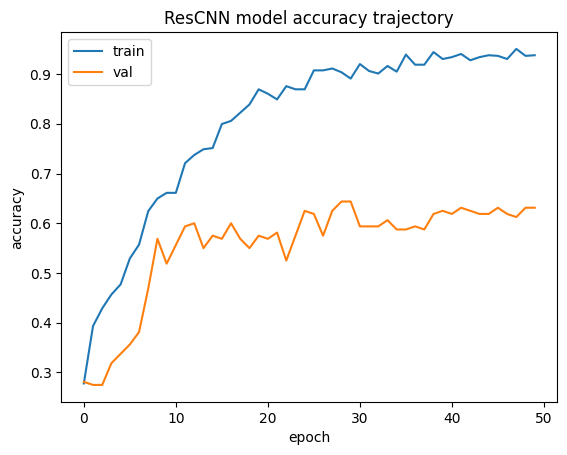

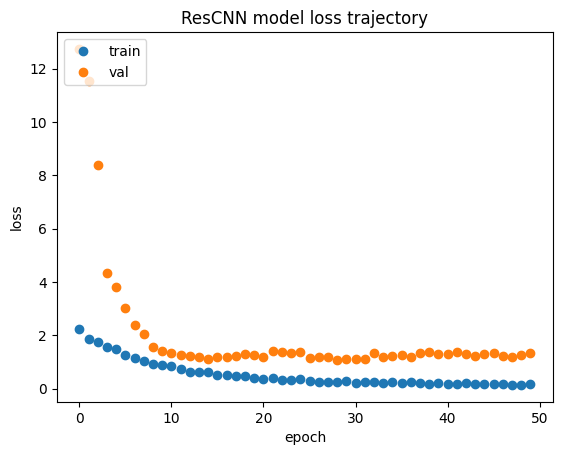

Test accuracy of the ResCNN model on Subject 1: 0.625


In [15]:
lr = 1e-3
epochs = 50
model_optimizer = keras.optimizers.Adam(learning_rate=lr)

# Compiling the model
res_cnn_model.compile(loss='categorical_crossentropy',
                 optimizer=model_optimizer,
                 metrics=['accuracy'])

lr_callback = tf.keras.callbacks.ReduceLROnPlateau(patience = 10, factor = 0.5)  # reduces by a factor of 0.5 if validation loss doesn't improve for 10 epochs

## Preprocess a single person dataset 
person = 0  #Set which person you'd like to look at (from 0 to 8)
yp_train, yp_valid, yp_test, xp_train, xp_valid, xp_test = preprocessing(Xp_train_valid[person], Yp_train_valid[person], Xp_test[person], Yp_test[person])

# Training and validating the model on Subject 1 (person 0)
model_results = res_cnn_model.fit(xp_train,
             yp_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(xp_valid, yp_valid), 
             callbacks=[lr_callback],
             verbose=True)

# Plotting accuracy trajectory
plt.plot(model_results.history['accuracy'])
plt.plot(model_results.history['val_accuracy'])
plt.title('ResCNN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(model_results.history['loss'],'o')
plt.plot(model_results.history['val_loss'],'o')
plt.title('ResCNN model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Testing model 
model_score = res_cnn_model.evaluate(xp_test, yp_test, verbose=0)
print('Test accuracy of the ResCNN model on Subject 1:',model_score[1])

### Train on all subjects

Epoch 1/50
111/111 [==============================] - 28s 194ms/step - loss: 1.5269 - accuracy: 0.4628 - val_loss: 1.0128 - val_accuracy: 0.5779 - lr: 0.0010
Epoch 2/50
111/111 [==============================] - 20s 182ms/step - loss: 1.1577 - accuracy: 0.5294 - val_loss: 0.9975 - val_accuracy: 0.5829 - lr: 0.0010
Epoch 3/50
111/111 [==============================] - 20s 180ms/step - loss: 1.0578 - accuracy: 0.5671 - val_loss: 0.9507 - val_accuracy: 0.5871 - lr: 0.0010
Epoch 4/50
111/111 [==============================] - 20s 180ms/step - loss: 0.9986 - accuracy: 0.5968 - val_loss: 0.9398 - val_accuracy: 0.5963 - lr: 0.0010
Epoch 5/50
111/111 [==============================] - 20s 184ms/step - loss: 0.9225 - accuracy: 0.6237 - val_loss: 0.9028 - val_accuracy: 0.6424 - lr: 0.0010
Epoch 6/50
111/111 [==============================] - 19s 171ms/step - loss: 0.8798 - accuracy: 0.6454 - val_loss: 0.8855 - val_accuracy: 0.6424 - lr: 0.0010
Epoch 7/50
111/111 [==============================] 

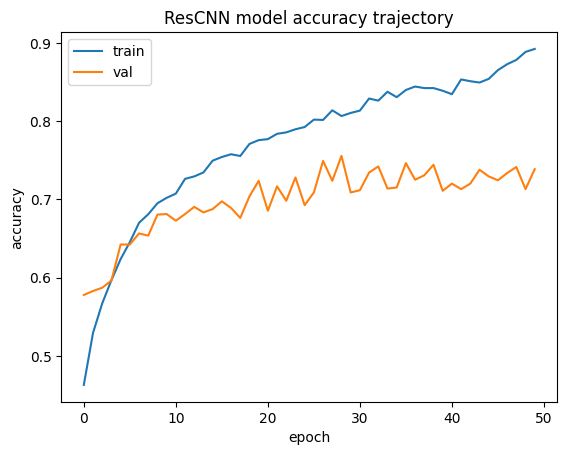

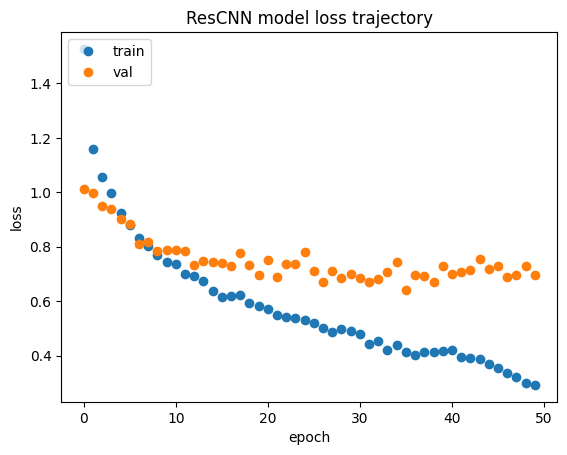

Test accuracy of the ResCNN model on all subjects: 0.7133182883262634


In [16]:
lr = 1e-3
epochs = 50
model_optimizer = keras.optimizers.Adam(learning_rate=lr)

# Compiling the model
res_cnn_model.compile(loss='categorical_crossentropy',
                 optimizer=model_optimizer,
                 metrics=['accuracy'])

lr_callback = tf.keras.callbacks.ReduceLROnPlateau(patience = 10, factor = 0.5)  # reduces by a factor of 0.5 if validation loss doesn't improve for 10 epochs

## Preprocess the entire dataset 
y_train, y_valid, y_test, x_train, x_valid, x_test = preprocessing(X_train_valid, Y_train_valid, X_test, Y_test)

# Training and validating the model
model_results = res_cnn_model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid, y_valid), 
             callbacks=[lr_callback],
             verbose=True)

# Plotting accuracy trajectory
plt.plot(model_results.history['accuracy'])
plt.plot(model_results.history['val_accuracy'])
plt.title('ResCNN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(model_results.history['loss'],'o')
plt.plot(model_results.history['val_loss'],'o')
plt.title('ResCNN model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Testing model 
model_score = res_cnn_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the ResCNN model on all subjects:',model_score[1])

### Test on Subject 1 after training on all subjects

In [17]:
# Testing model 
model_score = res_cnn_model.evaluate(xp_test, yp_test, verbose=0)
print('Test accuracy of the ResCNN model on Subject 1, trained on all subjects:',model_score[1])

Test accuracy of the ResCNN model on Subject 1, trained on all subjects: 0.6899999976158142


In [11]:
## Preprocess the entire dataset 
y_train, y_valid, y_test, x_train, x_valid, x_test = preprocessing(X_train_valid, Y_train_valid, X_test, Y_test)

# Building the CNN model using sequential class
model = Sequential()

# Conv. block 1
model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', input_shape=(250,1,22)))
model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Conv. block 2
model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Stacked GRUs 
model.add(Flatten()) 
model.add(Dense(100))
model.add(Reshape((100,1)))
model.add(GRU(64, return_sequences=True, recurrent_dropout=0.1, input_shape=(100,1))) 
model.add(Dropout(0.2))
model.add(GRU(32, return_sequences=True, recurrent_dropout=0.1)) 
model.add(Dropout(0.2))
model.add(GRU(10))

# Output Layer with Softmax Activation
model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 250, 1, 25)        5525      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 84, 1, 25)        0         
 2D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 84, 1, 25)        100       
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 84, 1, 25)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 84, 1, 50)         12550     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 28, 1, 50)        0

In [12]:
## Preprocess the entire dataset 
y_train, y_valid, y_test, x_train, x_valid, x_test = preprocessing(X_train_valid, Y_train_valid, X_test, Y_test)

# Building the CNN model using sequential class
model = Sequential()

# Conv. block 1
model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', input_shape=(250,1,22)))
model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Conv. block 2
model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Stacked GRUs 
model.add(Flatten()) 
model.add(Dense(100))
model.add(Reshape((100,1)))
model.add(GRU(64, return_sequences=True, recurrent_dropout=0.1, input_shape=(100,1))) 
model.add(Dropout(0.2))
model.add(GRU(32, return_sequences=True, recurrent_dropout=0.1)) 
model.add(Dropout(0.2))
model.add(GRU(10))

# Output Layer with Softmax Activation
model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation

model.summary()

lr = 1e-3
epochs = 50
model_optimizer = keras.optimizers.Adam(learning_rate=lr)

# Compiling the model
model.compile(loss='categorical_crossentropy',
                 optimizer=model_optimizer,
                 metrics=['accuracy'])

# Use checkpoints to save best validation accuracy model 
#checkpoint_filepath = r"C:\Users\zacha\OneDrive - UCLA IT Services\Documents\ZW - Academic\UCLA\UCLA MAE GRAD CLASSES\ECE C247 - Deep Learning\Final_Project\project\tmp\checkpoint"
#model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_accuracy', mode='max', save_best_only=True)

lr_callback = tf.keras.callbacks.ReduceLROnPlateau(patience = 10, factor = 0.5)  # reduces by a factor of 0.5 if validation loss doesn't improve for 10 epochs

# Training and validating the model
model_results = model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid, y_valid), 
             callbacks=[lr_callback],
             verbose=True)

# Plotting accuracy trajectory
plt.plot(model_results.history['accuracy'])
plt.plot(model_results.history['val_accuracy'])
plt.title('Model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(model_results.history['loss'],'o')
plt.plot(model_results.history['val_loss'],'o')
plt.title('Model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Testing model 
model_score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the hybrid CNN-LSTM model:',model_score[1])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 250, 1, 25)        5525      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 84, 1, 25)        0         
 2D)                                                             
                                                                 
 batch_normalization_6 (Batc  (None, 84, 1, 25)        100       
 hNormalization)                                                 
                                                                 
 dropout_8 (Dropout)         (None, 84, 1, 25)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 84, 1, 50)         12550     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 28, 1, 50)       

KeyboardInterrupt: 

## Loop for Building and Running Models 

In [ ]:
def NN_model(num, Xtv, Ytv, Xt, Yt, lr=1e-3, epochs=50, batch=64, dropout=0.2):
    ## Preprocess the dataset 
    y_train, y_valid, y_test, x_train, x_valid, x_test = preprocessing(Xtv, Ytv, Xt, Yt)
    
    ## Build the Model 
    model = Sequential() 
    
    #Insert Model HERE 
    # Conv. block 1
    model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', input_shape=(250,1,22)))
    model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    # Conv. block 2
    model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
    model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    # Stacked GRUs 
    model.add(Flatten()) 
    model.add(Dense(100))
    model.add(Reshape((100,1)))
    model.add(GRU(64, return_sequences=True, recurrent_dropout=0.1, input_shape=(100,1))) 
    model.add(Dropout(dropout))
    model.add(GRU(32, return_sequences=True, recurrent_dropout=0.1)) 
    model.add(Dropout(dropout))
    model.add(GRU(10))
    
    # Output Layer with Softmax Activation
    model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation
    
    model.summary() 
    
    ## Specify Model Parameters 
    model_optimizer = keras.optimizers.Adam(learning_rate = lr) 
    
    ## Compiling, Training, and Validating the Model 
    model.compile(loss='categorical_crossentropy', optimizer=model_optimizer, metrics=['accuracy'])
    
    checkpoint_filepath = r'C:\Users\zacha\OneDrive - UCLA IT Services\Documents\ZW - Academic\UCLA\UCLA MAE GRAD CLASSES\ECE C247 - Deep Learning\Final_Project\project\tmp\checkpoint{0}'.format(num)
    valacc_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_accuracy', mode='max', save_best_only=True)
    lr_callback = tf.keras.callbacks.ReduceLROnPlateau(patience = 10, factor = 0.5)  # reduces by a factor of 0.5 if validation loss doesn't improve for 10 epochs
    model_results = model.fit(x_train, y_train,
                    batch_size=batch,  #Default is 64
                    epochs=epochs,
                    validation_data=(x_valid, y_valid), 
                    callbacks=[valacc_callback, lr_callback], verbose=True)
    
    ## Visualizing the Accuracy and Loss Trajectory 
    # Plotting accuracy trajectory
    plt.plot(model_results.history['accuracy'])
    plt.plot(model_results.history['val_accuracy'])
    plt.title('Model accuracy trajectory')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    # Plotting loss trajectory
    plt.plot(model_results.history['loss'],'o')
    plt.plot(model_results.history['val_loss'],'o')
    plt.title('Hybrid CNN-LSTM model loss trajectory')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    ## Testing Performance of the Model 
    model_score = model.evaluate(x_test, y_test, verbose=0)
    print('Test accuracy of the hybrid CNN-LSTM model:',model_score[1])
    
    # Load best validation accuracy weights 
    model.load_weights(checkpoint_filepath)
    
    model_score = model.evaluate(x_test, y_test, verbose=0)
    print('Test accuracy of the hybrid CNN-LSTM model:',model_score[1])

In [ ]:
num = 0 

batch = [32,64,128]  #256, 512
dropout = [0.1, 0.3, 0.6] 

for b in batch:
    for d in dropout: 
        NN_model(num, X_train_valid, Y_train_valid, X_test, Y_test, batch=b, dropout=d)
        num += 1 

|Model#|Batch|Dropout|Epochs|LR|ValAcc|TestAcc| 
|------|-----|-------|------|--|------|-------|
|0|32 |0.1|50|1e-3|
|1|32 |0.3|50|1e-3|
|2|32 |0.6|50|1e-3|
|3|64 |0.1|50|1e-3|
|4|64 |0.3|50|1e-3|
|5|64 |0.6|50|1e-3|
|6|128|0.1|50|1e-3|
|7|128|0.3|50|1e-3|
|8|128|0.6|50|1e-3|